In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
from matplotlib import pyplot

In [ ]:
data_path = "/content/drive/MyDrive/Novices Data Set and Model/";

(417, 224, 224, 3)


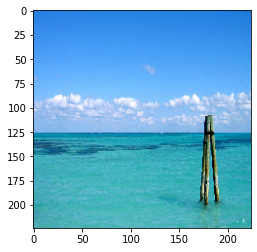

In [ ]:
# non_nude_dataset 1
loaded_non_nude_1 = np.load(data_path+'non_nude_dataset.npz')
loaded_non_nude_1_temp = loaded_non_nude_1['arr_0']
print(loaded_non_nude_1_temp.shape)

for i in loaded_non_nude_1_temp:
  pyplot.imshow(i)
  pyplot.show()
  break

(500, 224, 224, 3)


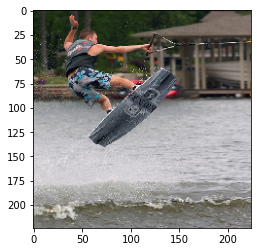

In [ ]:
# non_nude_dataset 2
loaded_non_nude_2 = np.load(data_path+'non_nude_dataset_1.npz')
loaded_non_nude_2_temp = loaded_non_nude_2['arr_0']
print(loaded_non_nude_2_temp.shape)

for i in loaded_non_nude_2_temp:
  pyplot.imshow(i)
  pyplot.show()
  break

(344, 224, 224, 3)


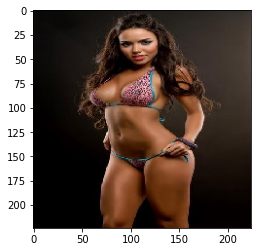

In [ ]:
# nude_dataset
loaded_nude = np.load(data_path+'nude_dataset.npz')
loaded_nude_temp = loaded_nude['arr_0']
print(loaded_nude_temp.shape)

for i in loaded_nude_temp:
  pyplot.imshow(i)
  pyplot.show()
  break

In [ ]:
# nude = make_data_set(data_path,"nude")
# np.savez_compressed("nude_dataset.npz",nude)
# loaded = np.load('nude_dataset.npz')
# nude_data = loaded['arr_0']
# print(nude_data.shape)

# for i in nude_data:
#   pyplot.imshow(i)
#   pyplot.show()
#   break

In [ ]:
x_train=[]
for i in loaded_non_nude_1_temp:
    x_train.append(i)
for k in loaded_non_nude_2_temp:
    x_train.append(k)

for j in loaded_nude_temp:
    x_train.append(j)
x_train = np.array(x_train)
print(x_train.shape)

(1261, 224, 224, 3)


In [ ]:
zero_y = np.zeros(len(loaded_non_nude_1_temp)+len(loaded_non_nude_2_temp))
one_y = np.ones(len(loaded_nude_temp))
y_train=[]
for i in zero_y:
  y_train.append(i)
for j in one_y:
  y_train.append(j)
y_train = np.array(y_train)
print(y_train.shape)

(1261,)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

device_name = tf.test.gpu_device_name()
print(device_name)
with tf.device(device_name):
  pass

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    # x = layers.Activation("relu")(x)
    x = keras.layers.LeakyReLU(alpha=0.3)(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    # x = layers.Activation("relu")(x)
    x = keras.layers.LeakyReLU(alpha=0.3)(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    # x = layers.Activation("relu")(x)
    x = keras.layers.LeakyReLU(alpha=0.3)(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        # x = layers.Activation("relu")(x)
        x = keras.layers.LeakyReLU(alpha=0.3)(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # x = layers.Activation("relu")(x)
        x = keras.layers.LeakyReLU(alpha=0.3)(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)

        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    # x = layers.Activation("relu")(x)
    x = keras.layers.LeakyReLU(alpha=0.3)(x)

    x = layers.GlobalAveragePooling2D()(x)
    
    activation = "sigmoid"
    units = 1

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

image_size = (224, 224)
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

In [ ]:
epochs = 100
batch_size = 16

callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),]
model.compile(optimizer=keras.optimizers.Adam(1e-3),loss="binary_crossentropy",metrics=["accuracy"],)


In [ ]:
with tf.device(device_name):
  model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, callbacks=callbacks, validation_data=(x_train, y_train))

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/Novices Data Set and Model/sexually_content_detection_model.h5")

In [ ]:
model.summary()

In [ ]:
predicted_y = model.predict(x_train)


In [ ]:
predicted_y = np.array([float(round(i[0])) for i in predicted_y])

In [ ]:
# predicted_y[170:]

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

accuracy_score_test = round(accuracy_score(y_train, predicted_y),2)
print(accuracy_score_test)

0.95


In [ ]:
confusion_matrix(y_train, predicted_y)

array([[906,  11],
       [ 55, 289]])

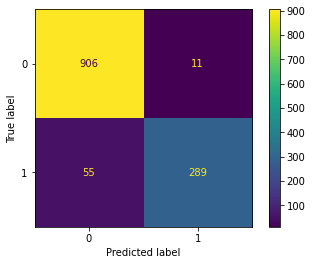

In [ ]:
cm = confusion_matrix(y_train, predicted_y)#, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#display_labels=clf.classes_)
disp.plot()
pyplot.show()

In [ ]:
from keras.preprocessing.image import load_img
image_path = "/content/dbNudeDetection/nude01.jpg"
image_data_test = load_img(image_path,target_size=(224,224))
image_data_test = np.array(image_data_test)
image_data_test = image_data_test.reshape((1,224,224,3))
predict_test_image = model.predict(image_data_test)
predict_test_image = round(predict_test_image[0][0])
# predict_test_image[0][0]

In [ ]:
if int(predict_test_image) == 0:
  print('Child Safe')
else:
  print('Not Child Safe')

Not Child Safe


In [ ]:
from sklearn.metrics import *

In [ ]:
target_names = ['class of Good Image', 'class of Not Good Image']
print(classification_report(y_train, predicted_y, target_names=target_names))

                         precision    recall  f1-score   support

    class of Good Image       0.94      0.99      0.96       917
class of Not Good Image       0.96      0.84      0.90       344

               accuracy                           0.95      1261
              macro avg       0.95      0.91      0.93      1261
           weighted avg       0.95      0.95      0.95      1261



In [ ]:
print("F1 score by built-in function: ",f1_score(y_train, predicted_y))

F1 score by built-in function:  0.8975155279503108


In [ ]:
print('Accuracy:', accuracy_score(y_train, predicted_y))

print ('F1 score:', f1_score(y_train, predicted_y,
                            average='weighted'))

print ('Recall:', recall_score(y_train, predicted_y,
                              average='weighted'))

print ('Precision:', precision_score(y_train, predicted_y,
                                    average='weighted'))

print ('\n clasification report:\n', classification_report(y_train, predicted_y,target_names=target_names))

print ('\n confussion matrix:\n',confusion_matrix(y_train, predicted_y))

Accuracy: 0.9476605868358445
F1 score: 0.946485729226173
Recall: 0.9476605868358445
Precision: 0.9483781735641376

 clasification report:
                          precision    recall  f1-score   support

    class of Good Image       0.94      0.99      0.96       917
class of Not Good Image       0.96      0.84      0.90       344

               accuracy                           0.95      1261
              macro avg       0.95      0.91      0.93      1261
           weighted avg       0.95      0.95      0.95      1261


 confussion matrix:
 [[906  11]
 [ 55 289]]
